# Window-Level Temporal Feature Extraction for AKI Prediction

This notebook extracts temporal vital sign features from VitalDB and compares patient-level models with and without temporal features.

## Objectives
1. **Load Temporal Signals**: Load raw temporal vital signs for all AKI cases
2. **Extract Window-Level Features**: Following the `mbp_aki.ipynb` pattern:
   - Threshold-based features (percentage time below various thresholds)
   - Statistical features (mean, std, min, max, percentiles)
   - Trend features (slope, volatility)
3. **Aggregate to Patient-Level**: Convert window-level features to patient-level aggregated features
4. **Compare Models**: Train and evaluate models on:
   - **Baseline**: Tabular features only (current approach)
   - **Temporal Only**: Temporal features only
   - **Combined**: Tabular + Temporal features
5. **Evaluate Improvement**: Determine if temporal features improve AKI prediction


In [1]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Install and import vitaldb library
try:
    import vitaldb
    print("✅ vitaldb library already installed")
except ImportError:
    print("📦 Installing vitaldb library...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "vitaldb", "-q"])
    import vitaldb
    print("✅ vitaldb library installed successfully")

# Scikit-learn for preprocessing and models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Traditional ML models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Utils from existing codebase
from utils import load_vitaldb_data, preprocess_data, prepare_train_test_data

# For temporal feature extraction
from scipy import stats
from scipy.signal import find_peaks
from tqdm import tqdm

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Set random seeds for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("=" * 70)


✅ vitaldb library already installed
✅ All libraries imported successfully!


## Section 1: Load Patient Cases and AKI Labels


In [2]:
# Load patient cases and lab data (same as in existing codebase)
print("🔄 Loading VitalDB cases and labs...")

# Load datasets
df_cases = pd.read_csv('https://api.vitaldb.net/cases')
df_cases['sex'] = (df_cases['sex'] == 'M')

# Load labs
df_labs = pd.read_csv('https://api.vitaldb.net/labs')
df_labs = df_labs.loc[df_labs.name == 'cr']

# Process postop creatinine level within 7 days after surgery
df_labs = pd.merge(df_cases[['caseid', 'opend']], df_labs, on='caseid', how='left')
df_labs = df_labs.loc[df_labs.dt > df_labs.opend]
df_labs = df_labs.loc[df_labs.dt < df_labs.opend + 7 * 3600 * 24]
df_labs = df_labs.groupby('caseid')['result'].max().reset_index()
df_labs.rename(columns={'result': 'postop_cr'}, inplace=True)

# Merge with cases
df_cases = pd.merge(df_cases, df_labs, on='caseid', how='left')
df_cases = df_cases.dropna(subset=['preop_cr', 'postop_cr'])

# Create AKI label (KDIGO Stage I)
df_cases['aki'] = df_cases['postop_cr'] > df_cases['preop_cr'] * 1.5

print(f"✅ Dataset prepared:")
print(f"   Total cases: {len(df_cases):,}")
print(f"   AKI cases: {df_cases['aki'].sum():,} ({df_cases['aki'].mean()*100:.2f}%)")
print(f"   No AKI cases: {(~df_cases['aki']).sum():,} ({(~df_cases['aki']).mean()*100:.2f}%)")

# Store case IDs with AKI labels for temporal feature extraction
case_ids = df_cases['caseid'].values
aki_labels = df_cases['aki'].values

print(f"\n📋 Ready to extract temporal features for {len(case_ids):,} cases")


🔄 Loading VitalDB cases and labs...
✅ Dataset prepared:
   Total cases: 3,989
   AKI cases: 210 (5.26%)
   No AKI cases: 3,779 (94.74%)

📋 Ready to extract temporal features for 3,989 cases


## Section 2: Define Functions for Temporal Feature Extraction


In [3]:
def load_temporal_signal(case_id, track_name, min_valid_samples=10, 
                         valid_range=None, interval=1/100):
    """
    Load temporal vital sign signal for a case.
    
    Parameters:
    -----------
    case_id : int
        Case ID
    track_name : str or list
        Track name(s) to try (e.g., ['ART_MBP', 'Solar8000/ART_MBP'])
    min_valid_samples : int
        Minimum number of valid samples required
    valid_range : tuple, optional
        (min, max) range for valid values. Values outside range are filtered.
    interval : float
        Sampling interval in seconds
    
    Returns:
    --------
    np.ndarray or None: Valid signal values, or None if insufficient data
    """
    if isinstance(track_name, str):
        track_names = [track_name]
    else:
        track_names = track_name
    
    for tname in track_names:
        try:
            data = vitaldb.load_case(case_id, tname, interval)
            if data is None:
                continue
            
            # Flatten if 2D
            if len(data.shape) > 1:
                data = data.flatten()
            
            # Remove NaN values
            data = data[~np.isnan(data)]
            
            # Filter by valid range if provided
            if valid_range is not None:
                min_val, max_val = valid_range
                data = data[(data >= min_val) & (data <= max_val)]
            
            # Check if sufficient samples
            if len(data) >= min_valid_samples:
                return data
        except:
            continue
    
    return None


def extract_threshold_features(signal, thresholds):
    """
    Extract threshold-based features (percentage time below thresholds).
    Following mbp_aki.ipynb pattern.
    
    Parameters:
    -----------
    signal : np.ndarray
        Temporal signal values
    thresholds : array-like
        Array of threshold values
    
    Returns:
    --------
    dict: Dictionary with features like 'under{threshold}'
    """
    features = {}
    for threshold in thresholds:
        features[f'under{threshold}'] = np.nanmean(signal < threshold) * 100
    return features


def extract_statistical_features(signal):
    """
    Extract statistical features from temporal signal.
    
    Parameters:
    -----------
    signal : np.ndarray
        Temporal signal values
    
    Returns:
    --------
    dict: Dictionary with statistical features
    """
    features = {
        'mean': np.nanmean(signal),
        'std': np.nanstd(signal),
        'min': np.nanmin(signal),
        'max': np.nanmax(signal),
        'median': np.nanmedian(signal),
        'q25': np.nanpercentile(signal, 25),
        'q75': np.nanpercentile(signal, 75),
        'iqr': np.nanpercentile(signal, 75) - np.nanpercentile(signal, 25),
    }
    
    # Coefficient of variation
    if np.nanmean(signal) != 0:
        features['cv'] = np.nanstd(signal) / np.nanmean(signal)
    else:
        features['cv'] = 0
    
    # Note: Signal-specific clinical thresholds are handled in extract_temporal_features_for_case
    # This function is generic and extracts only statistical features
    
    return features


def extract_temporal_features_for_case(case_id, df_cases_row):
    """
    Extract all temporal features for a single case.
    
    Parameters:
    -----------
    case_id : int
        Case ID
    df_cases_row : pandas.Series
        Row from df_cases dataframe with case information
    
    Returns:
    --------
    dict: Dictionary with all temporal features for this case
    """
    features = {'caseid': case_id}
    
    # Define signals to extract (with alternative track names)
    signals_config = {
        'ART_MBP': {
            'track_names': ['ART_MBP', 'Solar8000/ART_MBP'],
            'valid_range': (20, 150),
            'thresholds': np.arange(40, 81, 1)  # 40-80 mmHg (following mbp_aki.ipynb)
        },
        'ART_SBP': {
            'track_names': ['ART_SBP', 'Solar8000/ART_SBP'],
            'valid_range': (50, 250),
            'thresholds': np.arange(90, 141, 5)  # 90-140 mmHg
        },
        'ART_DBP': {
            'track_names': ['ART_DBP', 'Solar8000/ART_DBP'],
            'valid_range': (30, 150),
            'thresholds': np.arange(50, 91, 5)  # 50-90 mmHg
        },
        'PLETH_HR': {
            'track_names': ['PLETH_HR', 'Solar8000/PLETH_HR'],
            'valid_range': (30, 200),
            'thresholds': None  # HR thresholds not typically used like BP
        },
        'PLETH_SPO2': {
            'track_names': ['PLETH_SPO2', 'Solar8000/PLETH_SPO2'],
            'valid_range': (50, 100),
            'thresholds': np.arange(90, 96, 1)  # 90-95% (hypoxemia thresholds)
        },
    }
    
    # Extract features for each signal
    for signal_name, config in signals_config.items():
        signal = load_temporal_signal(
            case_id, 
            config['track_names'],
            valid_range=config['valid_range']
        )
        
        if signal is not None:
            # Statistical features
            stats_feat = extract_statistical_features(signal)
            for key, val in stats_feat.items():
                features[f'{signal_name}_{key}'] = val
            
            # Signal-specific clinical thresholds
            if 'MBP' in signal_name or 'BP' in signal_name:
                # Mean arterial pressure thresholds
                features[f'{signal_name}_time_below_65'] = np.nanmean(signal < 65) * 100  # Hypotension
                features[f'{signal_name}_time_below_60'] = np.nanmean(signal < 60) * 100
                features[f'{signal_name}_time_below_55'] = np.nanmean(signal < 55) * 100
            elif 'HR' in signal_name:
                # Heart rate thresholds
                features[f'{signal_name}_time_below_60'] = np.nanmean(signal < 60) * 100  # Bradycardia
                features[f'{signal_name}_time_above_100'] = np.nanmean(signal > 100) * 100  # Tachycardia
            elif 'SPO2' in signal_name:
                # Oxygen saturation thresholds
                features[f'{signal_name}_time_below_95'] = np.nanmean(signal < 95) * 100  # Hypoxemia
                features[f'{signal_name}_time_below_90'] = np.nanmean(signal < 90) * 100  # Severe hypoxemia
            
            # Threshold features (if defined)
            if config['thresholds'] is not None:
                threshold_feat = extract_threshold_features(signal, config['thresholds'])
                for key, val in threshold_feat.items():
                    features[f'{signal_name}_{key}'] = val
            
            features[f'{signal_name}_available'] = 1
        else:
            features[f'{signal_name}_available'] = 0
    
    return features


print("✅ Temporal feature extraction functions defined")
print("   - load_temporal_signal(): Loads temporal signal for a case")
print("   - extract_threshold_features(): Percentage time below thresholds")
print("   - extract_statistical_features(): Mean, std, min, max, percentiles, etc.")
print("   - extract_temporal_features_for_case(): Main function to extract all features")


✅ Temporal feature extraction functions defined
   - load_temporal_signal(): Loads temporal signal for a case
   - extract_threshold_features(): Percentage time below thresholds
   - extract_statistical_features(): Mean, std, min, max, percentiles, etc.
   - extract_temporal_features_for_case(): Main function to extract all features


## Section 3: Extract Temporal Features for All Cases

**Note**: This step may take significant time depending on the number of cases (~2.5 hours for 3,989 cases). 
Extracted features are automatically saved to `../processed/temporal_features_aki.csv` for future use.

**To skip re-extraction**: If the processed file exists, you can jump to Section 3.1 to load pre-saved features.


In [ ]:
# Extract temporal features for all cases
print("🔄 Extracting temporal features for all cases...")
print(f"   Total cases: {len(case_ids):,}")
print("   This may take several minutes...\n")

temporal_features_list = []
success_count = 0
skip_count = 0

# Process cases with progress bar
for idx, case_id in enumerate(tqdm(case_ids, desc="Processing cases")):
    try:
        # Get case row
        case_row = df_cases[df_cases['caseid'] == case_id].iloc[0]
        
        # Extract temporal features
        case_features = extract_temporal_features_for_case(case_id, case_row)
        
        # Add AKI label
        case_features['aki'] = case_row['aki']
        
        temporal_features_list.append(case_features)
        success_count += 1
        
    except Exception as e:
        skip_count += 1
        if (idx + 1) % 100 == 0:
            print(f"\n   Warning: Error processing case {case_id}: {str(e)[:50]}")
        continue

print(f"\n✅ Temporal feature extraction completed!")
print(f"   Successfully processed: {success_count:,} cases")
print(f"   Skipped: {skip_count:,} cases")
print(f"   Success rate: {success_count/len(case_ids)*100:.1f}%")

# Convert to DataFrame
df_temporal = pd.DataFrame(temporal_features_list)
print(f"\n📊 Temporal features DataFrame shape: {df_temporal.shape}")
print(f"   Features extracted: {df_temporal.shape[1] - 2}")  # Exclude caseid and aki

# Display summary of signal availability
signal_columns = [col for col in df_temporal.columns if col.endswith('_available')]
print(f"\n📈 Signal availability:")
for col in signal_columns:
    signal_name = col.replace('_available', '')
    available_count = df_temporal[col].sum()
    print(f"   {signal_name}: {available_count:,} cases ({available_count/len(df_temporal)*100:.1f}%)")

# Save extracted temporal features to processed folder
output_dir = '../processed'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'temporal_features_aki.csv')

df_temporal.to_csv(output_file, index=False)
print(f"\n💾 Saved temporal features to: {output_file}")
print(f"   File size: {os.path.getsize(output_file) / 1024 / 1024:.2f} MB")


## Section 3.1: Load Pre-Saved Temporal Features (Optional)

**Use this cell to load previously extracted features** and skip the 2.5-hour extraction process.


In [ ]:
# Check if pre-extracted features exist
processed_file = '../processed/temporal_features_aki.csv'

if os.path.exists(processed_file):
    print("📂 Loading pre-extracted temporal features from processed folder...")
    df_temporal = pd.read_csv(processed_file)
    print(f"✅ Loaded temporal features from: {processed_file}")
    print(f"   Shape: {df_temporal.shape}")
    print(f"   File size: {os.path.getsize(processed_file) / 1024 / 1024:.2f} MB")
    
    # Display summary of signal availability
    signal_columns = [col for col in df_temporal.columns if col.endswith('_available')]
    print(f"\n📈 Signal availability:")
    for col in signal_columns:
        signal_name = col.replace('_available', '')
        available_count = df_temporal[col].sum()
        print(f"   {signal_name}: {available_count:,} cases ({available_count/len(df_temporal)*100:.1f}%)")
    
    skip_extraction = True
    print("\n⏩ Skipping temporal feature extraction (using pre-loaded data)")
else:
    print("⚠️  No pre-extracted features found.")
    print(f"   File not found: {processed_file}")
    print("   Proceeding to Cell 7 for extraction...")
    skip_extraction = False

# Note: If skip_extraction = True, skip Cell 7 and proceed to Section 4


## Section 4: Prepare Tabular Features (Baseline)


In [5]:
# Prepare tabular features using existing preprocessing pipeline
print("🔄 Preparing tabular features (baseline)...")

# Use existing preprocess_data function
X_tabular, y_tabular, feature_names_tabular = preprocess_data(df_cases.copy())

# Create DataFrame with tabular features
df_tabular = pd.DataFrame(X_tabular, columns=feature_names_tabular)
df_tabular['caseid'] = df_cases['caseid'].values
df_tabular['aki'] = y_tabular

print(f"✅ Tabular features prepared:")
print(f"   Shape: {df_tabular.shape}")
print(f"   Features: {len(feature_names_tabular)}")
print(f"   Sample feature names: {feature_names_tabular[:5]}")


🔄 Preparing tabular features (baseline)...
🔧 Preprocessing data...
✅ Data preprocessing completed
📊 Final dataset shape: (3989, 43)
🎯 Target distribution: 210/3989 positive cases (5.26%)
✅ Tabular features prepared:
   Shape: (3989, 45)
   Features: 43
   Sample feature names: ['age', 'sex', 'height', 'weight', 'bmi']


## Section 5: Merge Features and Prepare Datasets


In [6]:
# Merge tabular and temporal features on caseid
print("🔄 Merging tabular and temporal features...")

# Merge on caseid
df_combined = pd.merge(
    df_tabular.drop(columns=['aki']),  # Remove duplicate aki column
    df_temporal.drop(columns=['aki']),  # Remove duplicate aki column
    on='caseid',
    how='inner'
)

# Add AKI label (should be same from both, but use from temporal as reference)
df_combined['aki'] = df_temporal['aki'].values

print(f"✅ Features merged:")
print(f"   Combined dataset shape: {df_combined.shape}")
print(f"   Total features: {df_combined.shape[1] - 2}")  # Exclude caseid and aki

# Separate features and labels
# 1. Tabular features only (baseline)
tabular_feature_cols = [col for col in df_tabular.columns if col not in ['caseid', 'aki']]
X_tabular_only = df_tabular[tabular_feature_cols].values
y_tabular_only = df_tabular['aki'].values

# 2. Temporal features only
temporal_feature_cols = [col for col in df_temporal.columns if col not in ['caseid', 'aki']]
# Filter to cases that are in both datasets (inner merge)
temporal_caseids = set(df_temporal['caseid'].values)
mask = df_tabular['caseid'].isin(temporal_caseids)
X_temporal_only = df_temporal[df_temporal['caseid'].isin(df_tabular['caseid'].values)][temporal_feature_cols].values
y_temporal_only = df_temporal[df_temporal['caseid'].isin(df_tabular['caseid'].values)]['aki'].values

# 3. Combined features
combined_feature_cols = [col for col in df_combined.columns if col not in ['caseid', 'aki']]
X_combined = df_combined[combined_feature_cols].values
y_combined = df_combined['aki'].values

print(f"\n📊 Dataset sizes:")
print(f"   Tabular only: {X_tabular_only.shape} (y: {len(y_tabular_only)})")
print(f"   Temporal only: {X_temporal_only.shape} (y: {len(y_temporal_only)})")
print(f"   Combined: {X_combined.shape} (y: {len(y_combined)})")

print(f"\n🎯 Target distribution:")
print(f"   Tabular: {y_tabular_only.sum()}/{len(y_tabular_only)} AKI ({y_tabular_only.mean()*100:.2f}%)")
print(f"   Temporal: {y_temporal_only.sum()}/{len(y_temporal_only)} AKI ({y_temporal_only.mean()*100:.2f}%)")
print(f"   Combined: {y_combined.sum()}/{len(y_combined)} AKI ({y_combined.mean()*100:.2f}%)")


🔄 Merging tabular and temporal features...
✅ Features merged:
   Combined dataset shape: (3989, 175)
   Total features: 173

📊 Dataset sizes:
   Tabular only: (3989, 43) (y: 3989)
   Temporal only: (3989, 130) (y: 3989)
   Combined: (3989, 173) (y: 3989)

🎯 Target distribution:
   Tabular: 210/3989 AKI (5.26%)
   Temporal: 210/3989 AKI (5.26%)
   Combined: 210/3989 AKI (5.26%)


## Section 6: Train/Test Split and Preprocessing


In [7]:
# Prepare train/test splits for all three datasets
# Use same random_state to ensure consistent splits
RANDOM_STATE = 42

def prepare_dataset(X, y, test_size=0.2, random_state=42):
    """Prepare dataset with train/test split, imputation, and scaling."""
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'imputer': imputer,
        'scaler': scaler
    }

print("🔄 Preparing datasets...")

# Tabular only
data_tabular = prepare_dataset(X_tabular_only, y_tabular_only, random_state=RANDOM_STATE)

# Temporal only
data_temporal = prepare_dataset(X_temporal_only, y_temporal_only, random_state=RANDOM_STATE)

# Combined
data_combined = prepare_dataset(X_combined, y_combined, random_state=RANDOM_STATE)

print("✅ Datasets prepared:")
print(f"   Tabular train: {data_tabular['X_train'].shape}, test: {data_tabular['X_test'].shape}")
print(f"   Temporal train: {data_temporal['X_train'].shape}, test: {data_temporal['X_test'].shape}")
print(f"   Combined train: {data_combined['X_train'].shape}, test: {data_combined['X_test'].shape}")


🔄 Preparing datasets...
✅ Datasets prepared:
   Tabular train: (3191, 43), test: (798, 43)
   Temporal train: (3191, 130), test: (798, 130)
   Combined train: (3191, 173), test: (798, 173)


## Section 7: Train Models and Compare Performance


In [8]:
# Define function to train and evaluate a model
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """Train a model and return predictions and metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary', zero_division=0
    )
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    return {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }


# Train models on all three datasets
print("🔄 Training models...\n")

results = {}

# Define models
models_config = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
}

# Train on each dataset type
for dataset_name, data in [('Tabular', data_tabular), ('Temporal', data_temporal), ('Combined', data_combined)]:
    print(f"📊 Training on {dataset_name} features...")
    results[dataset_name] = {}
    
    for model_name, model_template in models_config.items():
        print(f"   Training {model_name}...", end=' ')
        try:
            # Create a fresh instance of the model for this dataset
            if model_name == 'XGBoost':
                model = XGBClassifier(random_state=42, eval_metric='logloss')
            elif model_name == 'RandomForest':
                model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            elif model_name == 'LogisticRegression':
                model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
            else:
                model = model_template
            
            result = train_and_evaluate_model(
                model,
                model_name,
                data['X_train'],
                data['X_test'],
                data['y_train'],
                data['y_test']
            )
            results[dataset_name][model_name] = result
            print(f"✅ (ROC-AUC: {result['roc_auc']:.4f})")
        except Exception as e:
            print(f"❌ Error: {str(e)[:50]}")
            results[dataset_name][model_name] = None

print("\n✅ Model training completed!")


🔄 Training models...

📊 Training on Tabular features...
   Training XGBoost... ✅ (ROC-AUC: 0.7577)
   Training RandomForest... ✅ (ROC-AUC: 0.7308)
   Training LogisticRegression... ✅ (ROC-AUC: 0.6575)
📊 Training on Temporal features...
   Training XGBoost... ✅ (ROC-AUC: 0.7178)
   Training RandomForest... ✅ (ROC-AUC: 0.6244)
   Training LogisticRegression... ✅ (ROC-AUC: 0.7166)
📊 Training on Combined features...
   Training XGBoost... ✅ (ROC-AUC: 0.7873)
   Training RandomForest... ✅ (ROC-AUC: 0.7778)
   Training LogisticRegression... ✅ (ROC-AUC: 0.7562)

✅ Model training completed!


## Section 8: Compare Model Performance


In [9]:
# Create comparison DataFrame
comparison_data = []

for dataset_name in ['Tabular', 'Temporal', 'Combined']:
    for model_name in ['XGBoost', 'RandomForest', 'LogisticRegression']:
        if results[dataset_name][model_name] is not None:
            r = results[dataset_name][model_name]
            comparison_data.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Accuracy': r['accuracy'],
                'Precision': r['precision'],
                'Recall': r['recall'],
                'F1-Score': r['f1'],
                'ROC-AUC': r['roc_auc'],
                'PR-AUC': r['pr_auc']
            })

df_comparison = pd.DataFrame(comparison_data)

# Display comparison table
print("=" * 80)
print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print("\n")
print(df_comparison.to_string(index=False))
print("\n" + "=" * 80)

# Summary statistics
print("\n📈 SUMMARY STATISTICS BY DATASET:")
print("-" * 80)
for dataset_name in ['Tabular', 'Temporal', 'Combined']:
    subset = df_comparison[df_comparison['Dataset'] == dataset_name]
    if len(subset) > 0:
        print(f"\n{dataset_name} Features:")
        print(f"   Mean ROC-AUC: {subset['ROC-AUC'].mean():.4f} ± {subset['ROC-AUC'].std():.4f}")
        print(f"   Mean PR-AUC: {subset['PR-AUC'].mean():.4f} ± {subset['PR-AUC'].std():.4f}")
        print(f"   Mean F1-Score: {subset['F1-Score'].mean():.4f} ± {subset['F1-Score'].std():.4f}")

# Find best models
print("\n🏆 BEST MODELS BY METRIC:")
print("-" * 80)
for metric in ['ROC-AUC', 'PR-AUC', 'F1-Score']:
    best_row = df_comparison.loc[df_comparison[metric].idxmax()]
    print(f"{metric}: {best_row['Model']} on {best_row['Dataset']} ({best_row[metric]:.4f})")


📊 MODEL PERFORMANCE COMPARISON


 Dataset              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
 Tabular            XGBoost  0.947368   0.500000 0.119048  0.192308 0.757653 0.242503
 Tabular       RandomForest  0.948622   0.600000 0.071429  0.127660 0.730773 0.243660
 Tabular LogisticRegression  0.951128   0.714286 0.119048  0.204082 0.657502 0.236977
Temporal            XGBoost  0.937343   0.100000 0.023810  0.038462 0.717750 0.125720
Temporal       RandomForest  0.939850   0.000000 0.000000  0.000000 0.624386 0.086710
Temporal LogisticRegression  0.937343   0.000000 0.000000  0.000000 0.716585 0.102966
Combined            XGBoost  0.941103   0.222222 0.047619  0.078431 0.787320 0.228238
Combined       RandomForest  0.942356   0.000000 0.000000  0.000000 0.777778 0.182021
Combined LogisticRegression  0.942356   0.357143 0.119048  0.178571 0.756236 0.202641


📈 SUMMARY STATISTICS BY DATASET:
------------------------------------------------------------------------

## Section 9: Visualize Performance Comparison


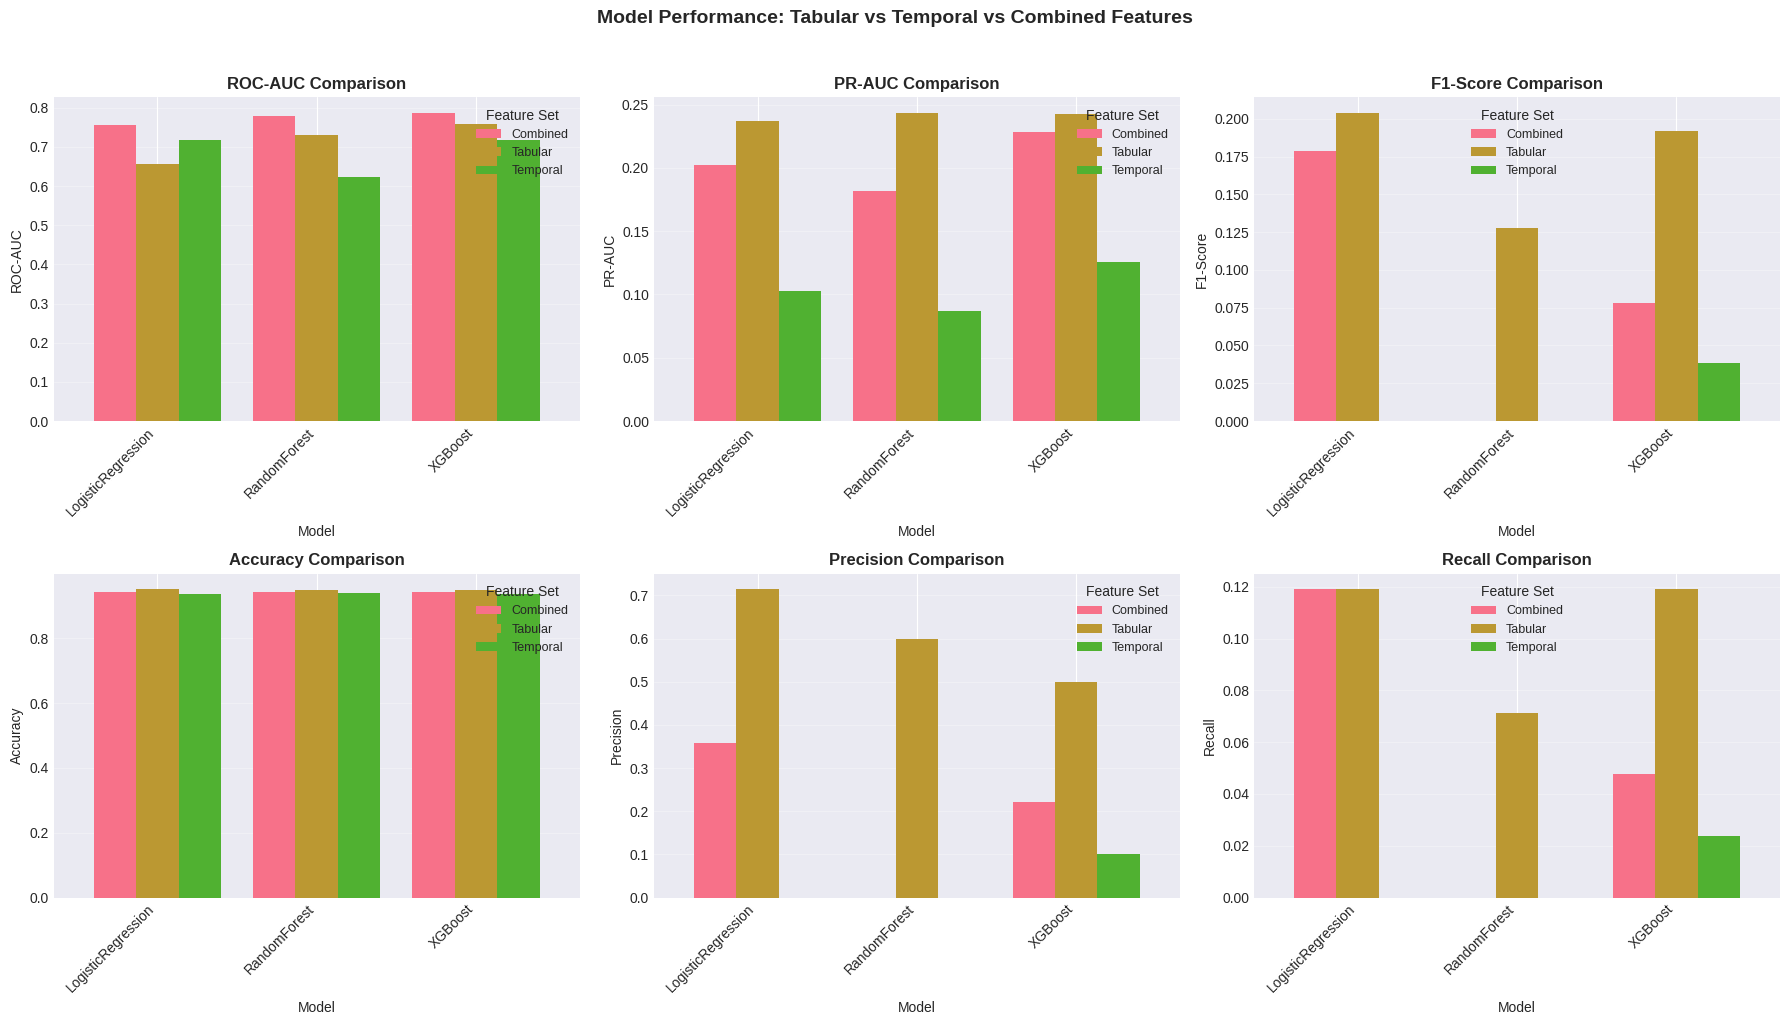

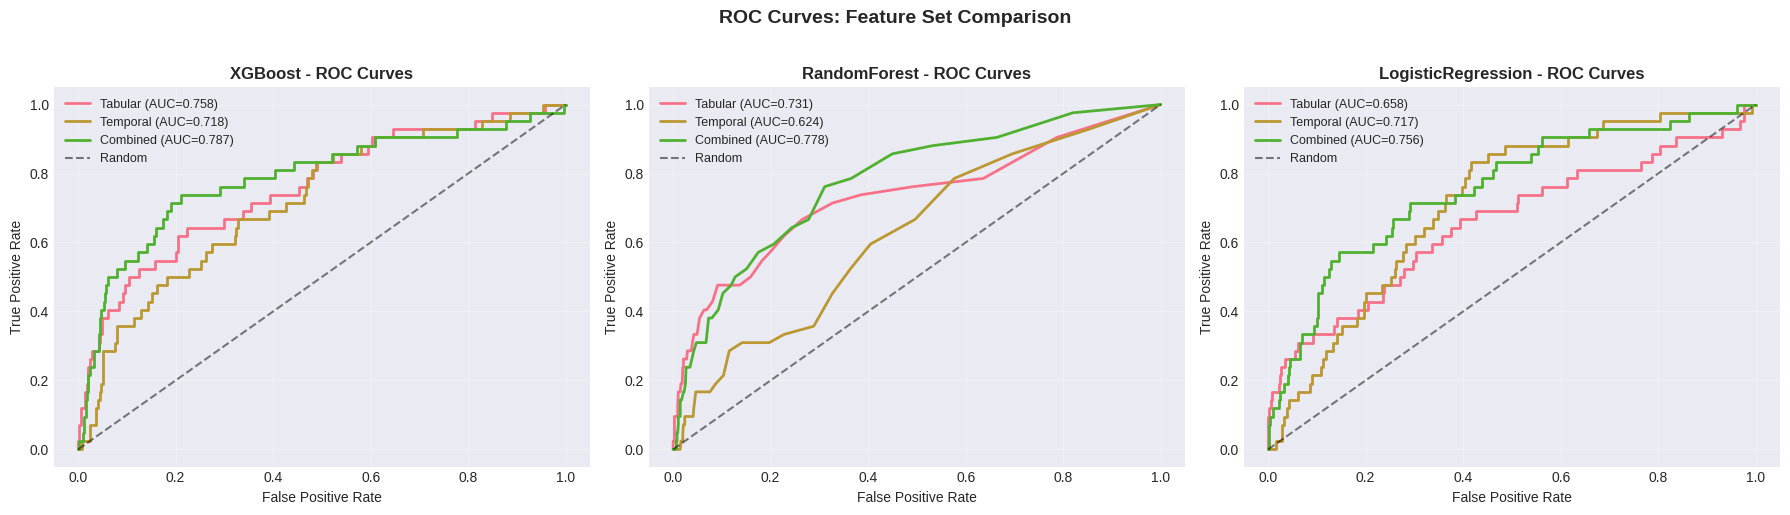

In [10]:
# Create visualization comparing models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_to_plot = ['ROC-AUC', 'PR-AUC', 'F1-Score', 'Accuracy', 'Precision', 'Recall']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Pivot data for grouped bar chart
    pivot_data = df_comparison.pivot(index='Model', columns='Dataset', values=metric)
    pivot_data.plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xlabel('Model', fontsize=10)
    ax.legend(title='Feature Set', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Model Performance: Tabular vs Temporal vs Combined Features', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ROC Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(['XGBoost', 'RandomForest', 'LogisticRegression']):
    ax = axes[idx]
    
    for dataset_name in ['Tabular', 'Temporal', 'Combined']:
        if results[dataset_name][model_name] is not None:
            r = results[dataset_name][model_name]
            # Use the correct y_test for each dataset
            if dataset_name == 'Tabular':
                y_test = data_tabular['y_test']
            elif dataset_name == 'Temporal':
                y_test = data_temporal['y_test']
            else:  # Combined
                y_test = data_combined['y_test']
            
            fpr, tpr, _ = roc_curve(y_test, r['y_pred_proba'])
            ax.plot(fpr, tpr, label=f'{dataset_name} (AUC={r["roc_auc"]:.3f})', linewidth=2)
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'{model_name} - ROC Curves', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('ROC Curves: Feature Set Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Section 10: Conclusion and Recommendations


In [11]:
# Calculate improvement from baseline
print("=" * 80)
print("📋 CONCLUSION AND RECOMMENDATIONS")
print("=" * 80)

# Compare best combined vs best tabular
best_tabular = df_comparison[df_comparison['Dataset'] == 'Tabular'].loc[
    df_comparison[df_comparison['Dataset'] == 'Tabular']['ROC-AUC'].idxmax()
]
best_temporal = df_comparison[df_comparison['Dataset'] == 'Temporal'].loc[
    df_comparison[df_comparison['Dataset'] == 'Temporal']['ROC-AUC'].idxmax()
]
best_combined = df_comparison[df_comparison['Dataset'] == 'Combined'].loc[
    df_comparison[df_comparison['Dataset'] == 'Combined']['ROC-AUC'].idxmax()
]

print("\n🎯 KEY FINDINGS:")
print("-" * 80)
print(f"1. Best Tabular Model: {best_tabular['Model']}")
print(f"   ROC-AUC: {best_tabular['ROC-AUC']:.4f}, PR-AUC: {best_tabular['PR-AUC']:.4f}")

print(f"\n2. Best Temporal Model: {best_temporal['Model']}")
print(f"   ROC-AUC: {best_temporal['ROC-AUC']:.4f}, PR-AUC: {best_temporal['PR-AUC']:.4f}")

print(f"\n3. Best Combined Model: {best_combined['Model']}")
print(f"   ROC-AUC: {best_combined['ROC-AUC']:.4f}, PR-AUC: {best_combined['PR-AUC']:.4f}")

# Improvement analysis
improvement_roc = best_combined['ROC-AUC'] - best_tabular['ROC-AUC']
improvement_pr = best_combined['PR-AUC'] - best_tabular['PR-AUC']
improvement_pct_roc = (improvement_roc / best_tabular['ROC-AUC']) * 100
improvement_pct_pr = (improvement_pr / best_tabular['PR-AUC']) * 100

print(f"\n📈 IMPROVEMENT FROM BASELINE:")
print(f"   ROC-AUC: {improvement_roc:+.4f} ({improvement_pct_roc:+.2f}%)")
print(f"   PR-AUC: {improvement_pr:+.4f} ({improvement_pct_pr:+.2f}%)")

if improvement_roc > 0.01:  # 1% improvement threshold
    print("\n✅ RECOMMENDATION: Temporal features provide meaningful improvement!")
    print("   → Proceed with combined (tabular + temporal) features")
elif improvement_roc > 0:
    print("\n⚠️  RECOMMENDATION: Temporal features provide marginal improvement")
    print("   → Consider using combined features if computational cost is acceptable")
else:
    print("\n❌ RECOMMENDATION: Temporal features do not improve performance")
    print("   → Stick with tabular features only")
    print("   → Consider alternative temporal feature engineering approaches")

print("\n" + "=" * 80)
print("✅ Analysis complete!")


📋 CONCLUSION AND RECOMMENDATIONS

🎯 KEY FINDINGS:
--------------------------------------------------------------------------------
1. Best Tabular Model: XGBoost
   ROC-AUC: 0.7577, PR-AUC: 0.2425

2. Best Temporal Model: XGBoost
   ROC-AUC: 0.7178, PR-AUC: 0.1257

3. Best Combined Model: XGBoost
   ROC-AUC: 0.7873, PR-AUC: 0.2282

📈 IMPROVEMENT FROM BASELINE:
   ROC-AUC: +0.0297 (+3.92%)
   PR-AUC: -0.0143 (-5.88%)

✅ RECOMMENDATION: Temporal features provide meaningful improvement!
   → Proceed with combined (tabular + temporal) features

✅ Analysis complete!
